# Lecture 3-4 Hands-on Session on Convolutional Networks


- Authors : Eis Annavini, Alessio Ansuini
- References : Neural Networks and Deep Learning, by Michael Nielsen

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
from keras.datasets import mnist
from keras import layers
from keras.models import Model, load_model
from keras import optimizers
from keras import losses
from keras import callbacks
from keras.utils.np_utils import to_categorical
from keras import regularizers
import os.path as path
import os
import pickle
from keras import backend as K
from tqdm import tnrange


jtplot.style(grid=False, ticks=True)

Using TensorFlow backend.


In [2]:
def show_test(model, validation_data):
    labels = np.argmax(model.predict(validation_data[0]), axis=1)
    ground_truth = np.argmax(validation_data[1], axis=1)
    accuracy = np.sum(labels != ground_truth)/labels.size
    num_errors = min(np.sum(labels != ground_truth), 20)
    errors = np.random.choice(np.nonzero(labels != ground_truth)[0], num_errors, replace=False)
    correct = np.random.choice(
        np.nonzero(labels == ground_truth)[0], 60 - num_errors, replace=False)
    stimuli = np.hstack((errors, correct))
    np.random.shuffle(stimuli)
    plt.style.use('grayscale')
    num_columns = 10
    num_rows = 6
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 3 * num_rows))
    for idx, ax in zip(stimuli, axes.ravel()):
        if idx in errors:
            c = 'r'
        else:
            c = 'k'
        ax.matshow(validation_data[0][idx, :, :, 0])
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title('Prediction: '+str(labels[idx])+
                     ' \n Truth: '+str(ground_truth[idx]), color=c)
    plt.suptitle("Model error rate: {:.2f}%".format(accuracy*100))
    plt.show()
    jtplot.style(grid=False, ticks=True)

In [3]:
#help(mnist.load_data)

(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_train, l_test = to_categorical(l_train), to_categorical(l_test)
i_validate = i_train[50000:, :, :, :]
i_train = i_train[0:50000, :, :, :]
l_validate = l_train[50000:, :]
l_train = l_train[0:50000, :]

In [4]:
if not path.isdir('models'):
    os.mkdir('models')

if path.isfile(path.join('models', 'training_hist.pkl')):
    print("Loading training history...")
    with open(path.join('models', 'training_hist.pkl'), 'rb') as f:
        history = pickle.load(f)

Loading training history...


# Fully Connected Network
----------------------------
<img src="Figures/mlp.png" alt="drawing" width="800" >

In this hands-on session we will expand the network we built to solve the MNIST digit classification problem to include convolutional layers, and we will see how this changes its behaviour and performance.

Let's start by rebuilding the last network we built in yesterday's hands-on session in Keras, and this will form the basis from which to move.

In [ ]:
minibatch_size = 10
n_epochs = 60
learn_rate = 0.1
history = {}
tb_params = {
    'write_images': True, 'histogram_freq': 5, 
    'write_grads': True, 'write_graph': False
            }
activation_fcn = 'sigmoid'

In [ ]:
# Define architecture

img = layers.Input(shape=(28, 28, 1,), name='images')
x = layers.Flatten()(img)
x = layers.Dense(100, activation=activation_fcn, name='hidden')(x)
out = layers.Dense(10, activation='softmax', name='output')(x)
model = Model(img, out)

In [7]:
print(model.input)
print(model.layers)
print(model.summary())

Tensor("images:0", shape=(?, 28, 28, 1), dtype=float32)
[<keras.engine.input_layer.InputLayer object at 0x7f2df2d0ab00>, <keras.layers.core.Flatten object at 0x7f2df2d0a470>, <keras.layers.core.Dense object at 0x7f2df2d0aef0>, <keras.layers.core.Dense object at 0x7f2df2d0ac18>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 100)               78500     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________

In [ ]:
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'fully_connected'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Fully Connected'] = h.history
history['Fully Connected']['epoch'] = h.epoch

model.save(path.join('models', 'fully_connected.h5'))

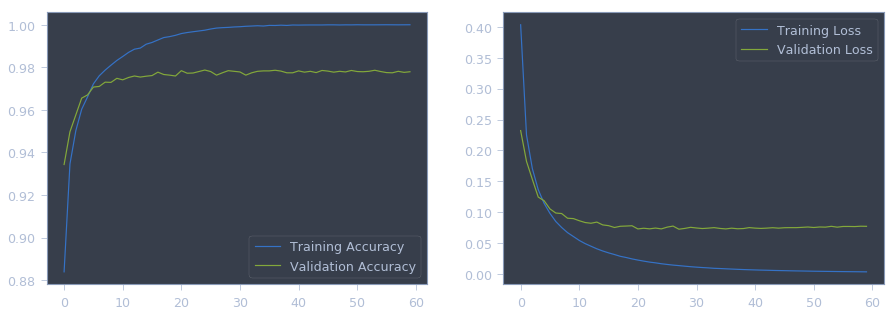

In [5]:
hist = history['Fully Connected']
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

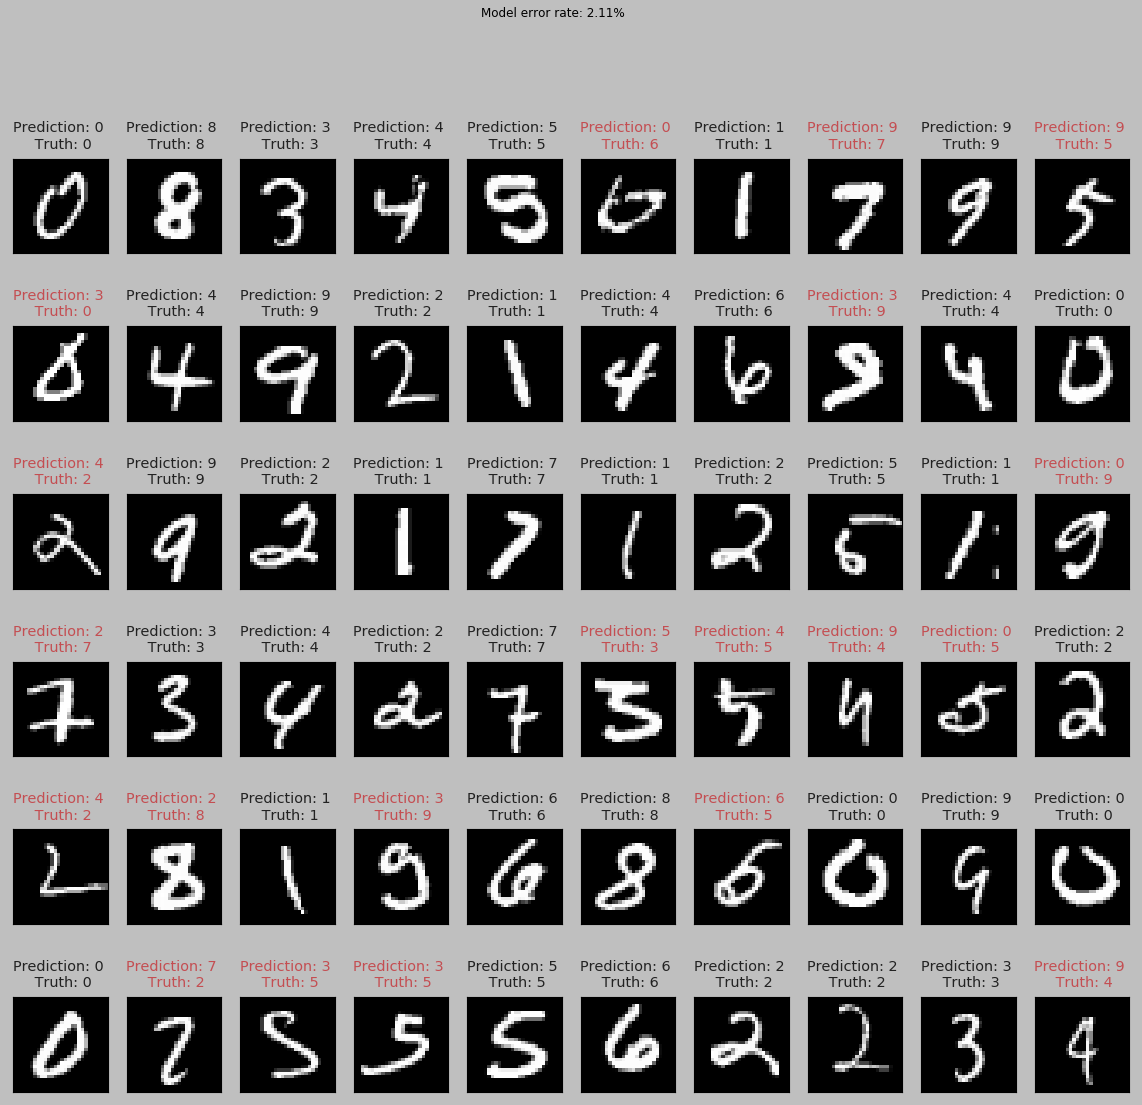

In [6]:
K.clear_session()
model = load_model(path.join('models', 'fully_connected.h5'))
show_test(model, (i_test, l_test))

# Convolutional (1 conv. layer)
--------------------------------------------------

<img src="Figures/simple_conv.png" alt="drawing" width="800" >

Now we will begin adding convolutional layers to our network. The syntax is really simple, and the code is quite self-explanatory; as a first step, we will complement our 1 hidden layer network with a single convolutional layer consisting of 20 banks of 5x5 filters followed by 2x2 max-pooling.

In [ ]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional'] = h.history
history['Convolutional']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional.h5'))

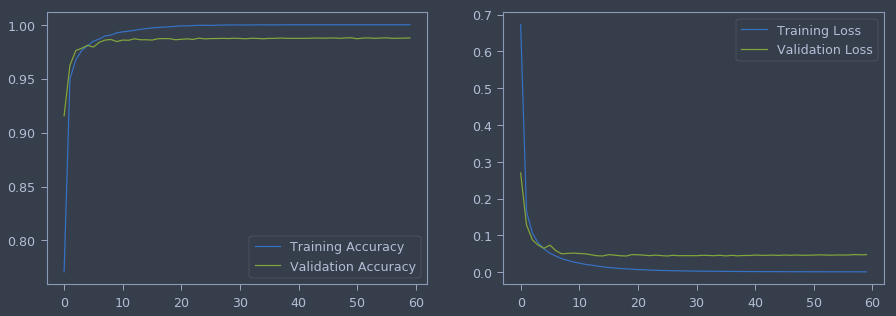

In [8]:
hist = history['Convolutional']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

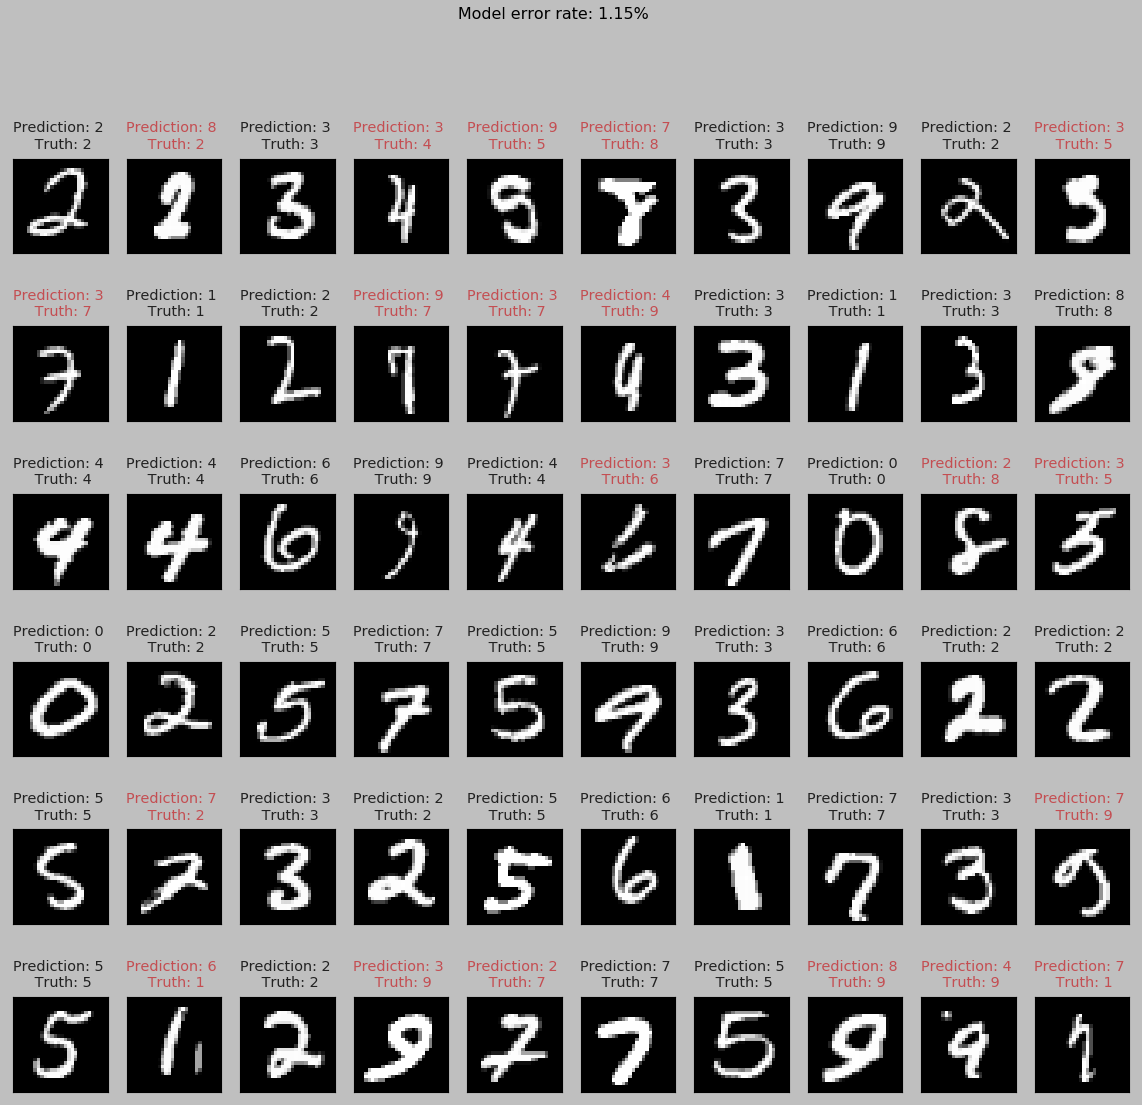

In [9]:
K.clear_session()
model = load_model(path.join('models', 'convolutional.h5'))
show_test(model, (i_test, l_test))

# Convolutional (2 conv. layers)

The next step is to add another convolutional layer, that builds more complex features by combining the ones emerging from the previous one. This time we will use 40 banks of 5x5 filters, also followed by 2x2 max-pooling

In [ ]:
K.clear_session()
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2layers'), **tb_params)
h = model.fit(
    i_train, l_train, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb]
    )
history['Convolutional (2 Layers)'] = h.history
history['Convolutional (2 Layers)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_2layers.h5'))

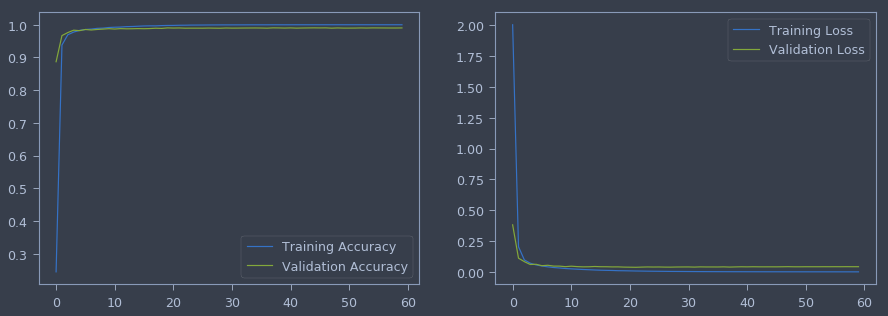

In [10]:
hist = history['Convolutional (2 Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

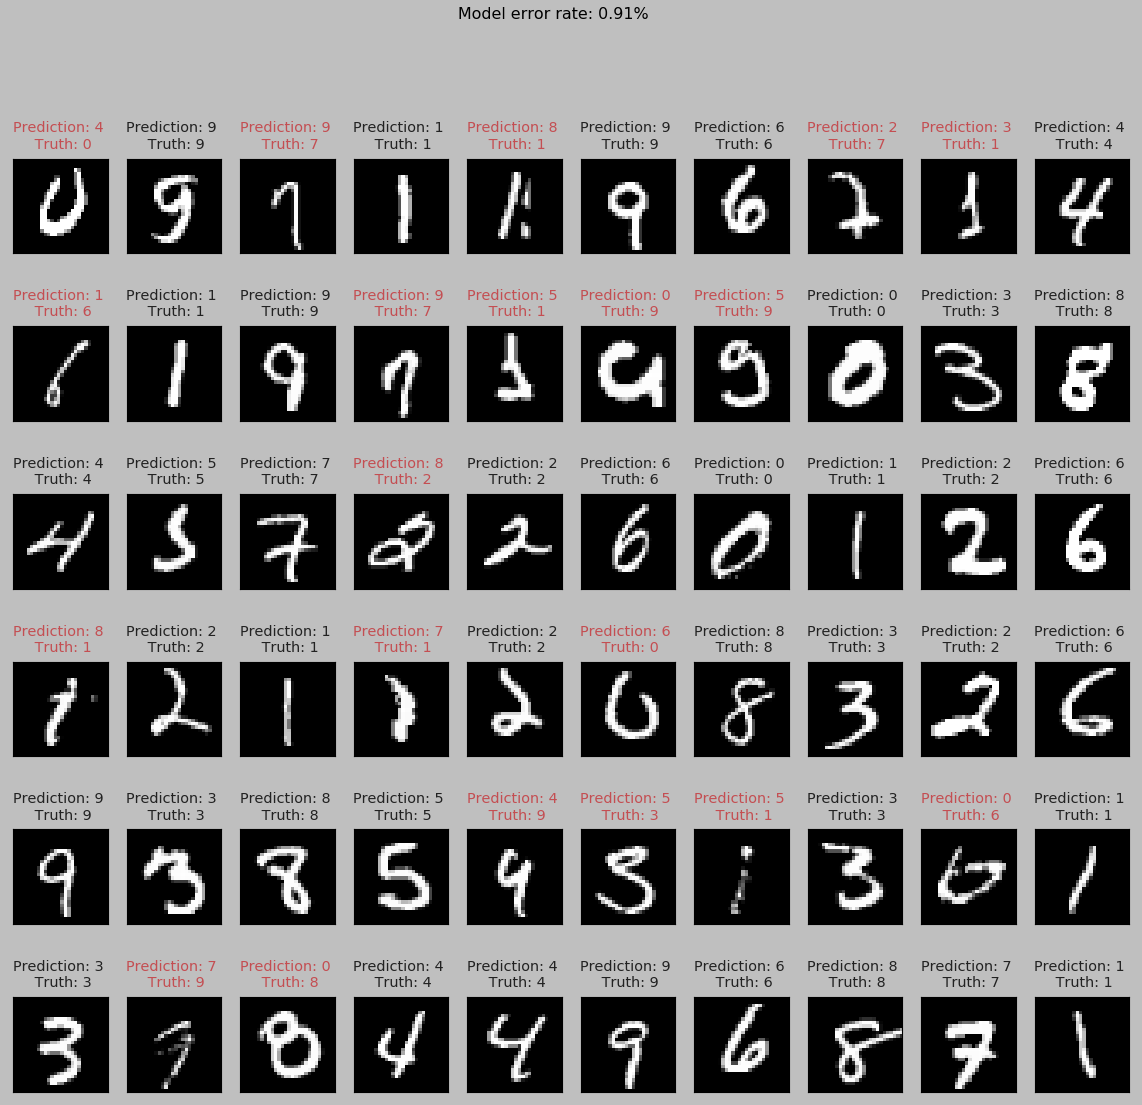

In [11]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_2layers.h5'))
show_test(model, (i_test, l_test))

# Enhanced MNIST
-------------------------------

<img src="Figures/data_augmentation.png" alt="drawing" width="800" >

You might have noticed that the performance on the training set saturated near 100%, which is usually a sign of overfitting. How can we address this situation, and improve the generalization capabilities of our network? One of the solutions is to apply to our stimulus set all the possible transformations it should be invariant to. As an example, for MNIST we have:
* Small translations
* Small rotations
* Elastic distortions

For the scope of this hands-on session we will enhance our stimulus set using only 1 pixel translations along the 4 cardinal directions (up, down, left, right). Also, to help reduce overfitting, we will add an $L_2$ weight regularization term to the cost function, which is defined as:
$$
C(a, y) = \mathcal{L}(a, y) \rightarrow C(a, y, \theta) = \mathcal{L}(a, y) + \frac{\lambda}{2n}|\theta|_2^2
$$
that is, for the cross-entropy,

$$
C(a, y) = \frac{1}{n}\sum_{x}\sum_{j} \left(y_j\log(a_j) + (1-y_j)\log(1-a_j)\right)
\rightarrow\\
C(a, y, \theta) = \frac{1}{n}\sum_{x}\sum_{j} \left(y_j\log(a_j) + (1-y_j)\log(1-a_j)\right) +
\frac{\lambda}{2n}|\theta|_2^2
$$

In [ ]:
def enhance_mnist(i_train, l_train, transf = [(1, 0), (-1, 0), (0, 1), (0, -1)]):
    i_enhanced = []
    l_enhanced = []
    for i in tnrange(i_train.shape[0]):
        img = i_train[i, :, :, :]
        label = l_train[i, :]
        i_enhanced.append(img)
        l_enhanced.append(label)
        for shift in transf:
            x = np.pad(img, ((abs(shift[0]), abs(shift[0])),
                         (abs(shift[1]), abs(shift[1])), (0, 0)), 'constant')
            x = np.roll(x, shift, (0, 1))
            x = x[abs(shift[0]):(x.shape[0]-abs(shift[0])),
                  abs(shift[1]):(x.shape[1]-abs(shift[1])), :]
            i_enhanced.append(x)
            l_enhanced.append(label)
    i_enhanced = np.array(i_enhanced)
    l_enhanced = np.array(l_enhanced)
    perm_idx = np.random.permutation(i_enhanced.shape[0])
    return i_enhanced[perm_idx, :, :, :], l_enhanced[perm_idx, :]

In [ ]:
i_enh, l_enh = enhance_mnist(i_train, l_train)

In [ ]:
activation_fcn = 'relu'
lmbd = 0.01
learn_rate = 0.03
minibatch_size = 10
minimum_lr = 1e-5

In [ ]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_relu'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)
h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (ReLU)'] = h.history
history['Convolutional (ReLU)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_relu.h5'))

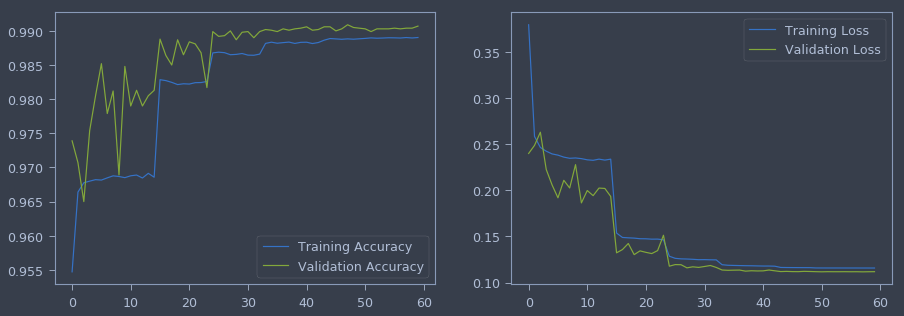

In [12]:
hist = history['Convolutional (ReLU)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

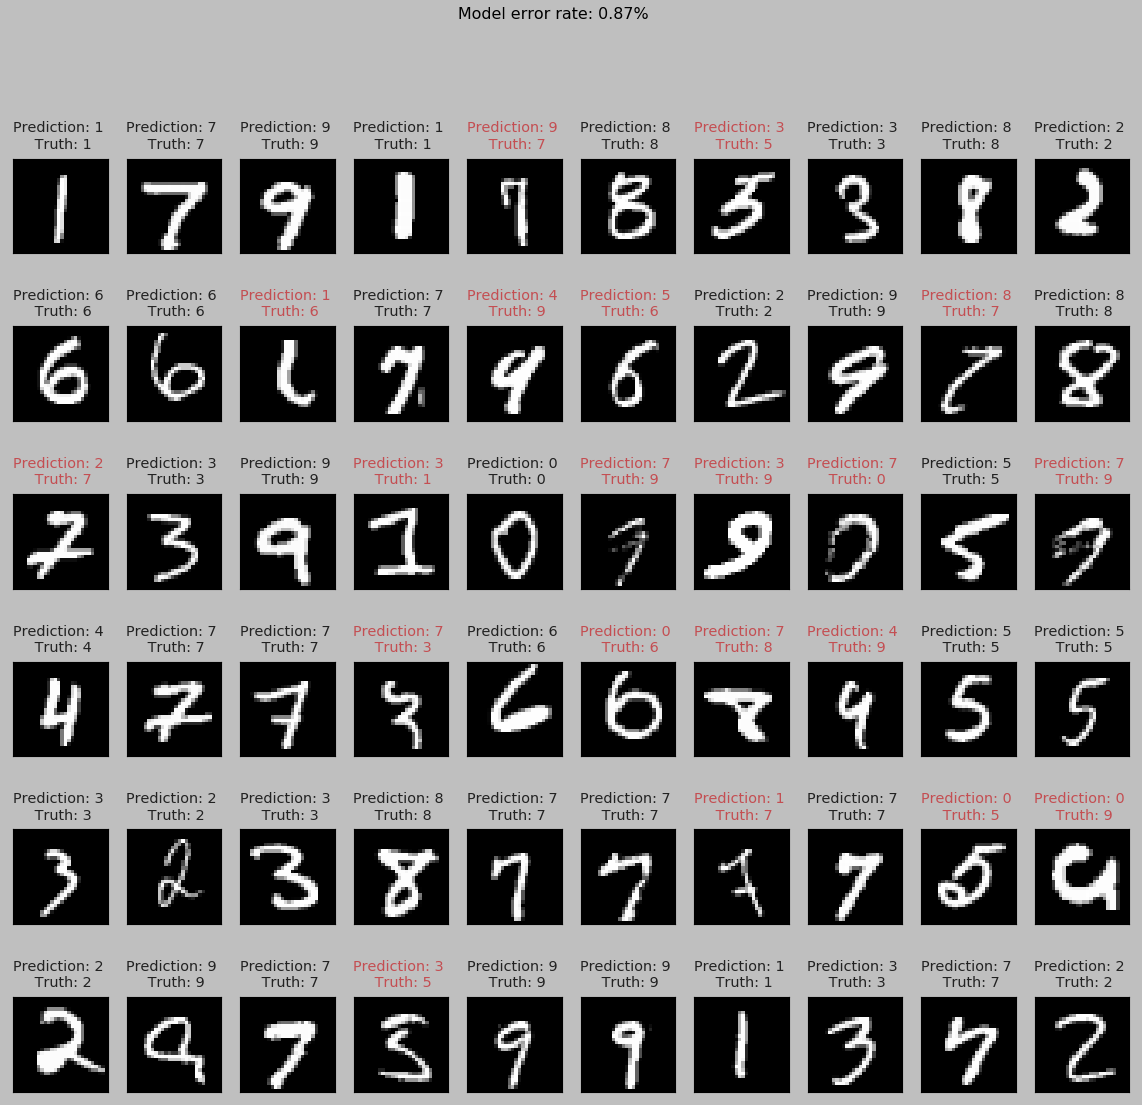

In [13]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_relu.h5'))
show_test(model, (i_test, l_test))

# Adding a dense layer
-------------------------------------

As a penultimate step we will add a second dense layer (this one too with 100 neurons) and see how this modification affects the performance

In [ ]:
K.clear_session()
regularization = regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dense(100, activation=activation_fcn, kernel_regularizer=regularization)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_2dense'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (2 Dense Layers)'] = h.history
history['Convolutional (2 Dense Layers)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_2dense.h5'))

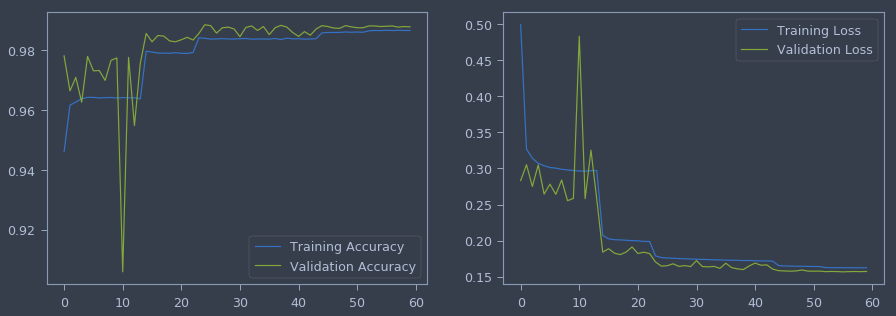

In [14]:
hist = history['Convolutional (2 Dense Layers)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

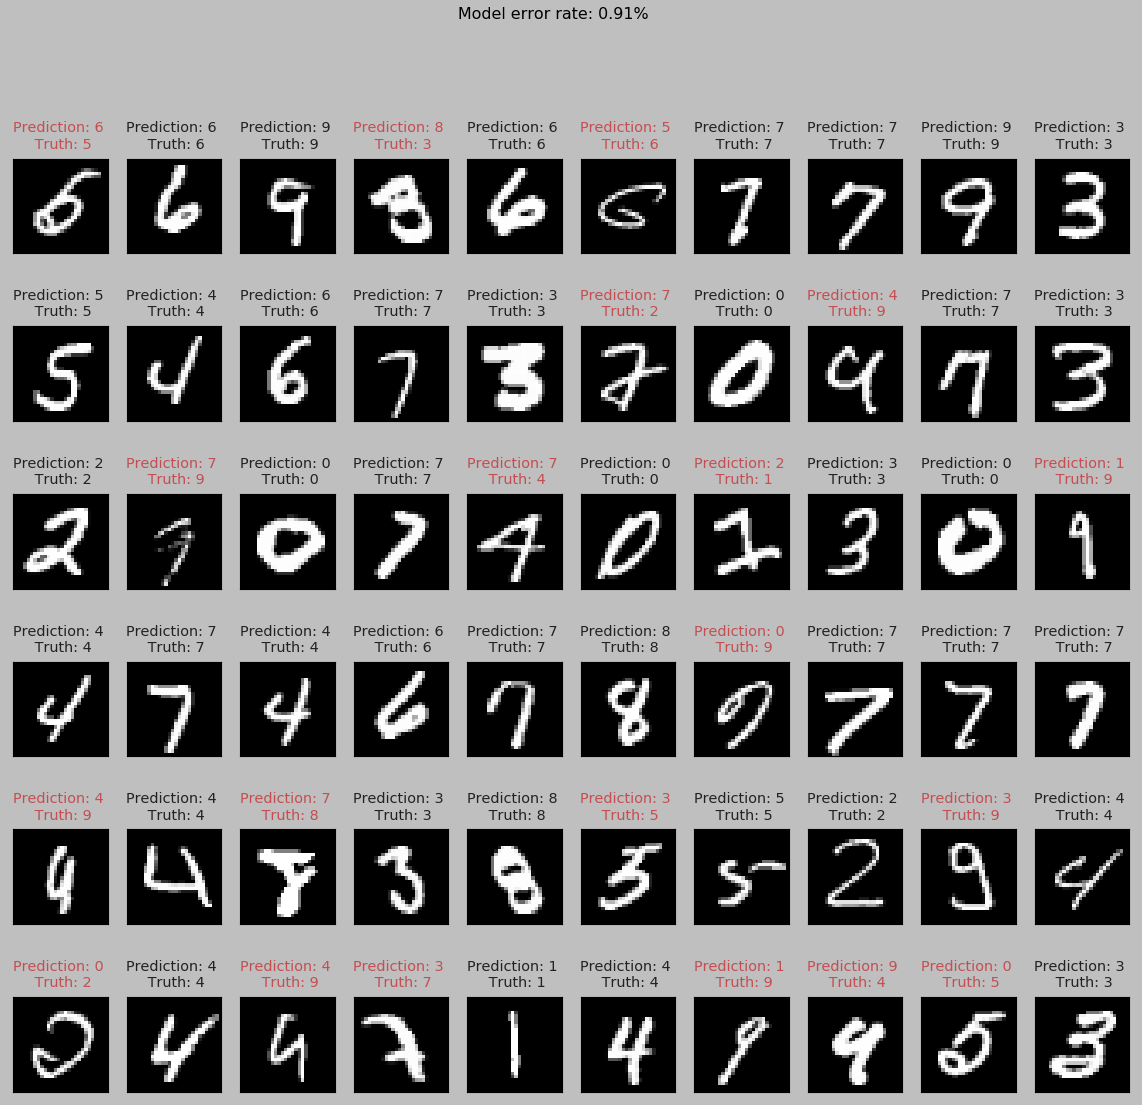

In [15]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_2dense.h5'))
show_test(model, (i_test, l_test))

# Dropout

<img src="Figures/dropout.png" alt="drawing" width="800" >

As we have seen, adding a second dense layer didn't do much good to the performance. Should we expand our dense layers? And if so, how can we avoid overfitting? To address this issue, we added dropout to the dense layers of our network. As you have seen yesterday, dropout is a regularization technique that removes the output of a random subset of neurons for each minibatch during training. This forces the network to rely on the presence of combinations of neurons rather than on the activations of a single, albeit very strong, unit, thus reducing overfitting. You could think dropout as the act of training several different networks, which will overfit in slightly different ways, and then averaging them together (thus reducing the magnitude of overfitting). Since dropout is a rather powerful regularization technique, we will omit the $L_2$ regularization term.

In [ ]:
K.clear_session()
regularization = None#regularizers.l2(lmbd)

img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn, kernel_regularizer=regularization)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1000, activation=activation_fcn, kernel_regularizer=regularization)(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

model = Model(img, out)
opt = optimizers.SGD(lr=learn_rate)
model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['accuracy'])
tb = callbacks.TensorBoard(log_dir=path.join('tb_data', 'convolutional_dropout'), **tb_params)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=minimum_lr, verbose=True)

h = model.fit(
    i_enh, l_enh, validation_data=(i_validate, l_validate), epochs=n_epochs,
    batch_size=minibatch_size, callbacks=[tb, reduce_lr]
    )
history['Convolutional (Dropout)'] = h.history
history['Convolutional (Dropout)']['epoch'] = h.epoch
model.save(path.join('models', 'convolutional_dropout.h5'))

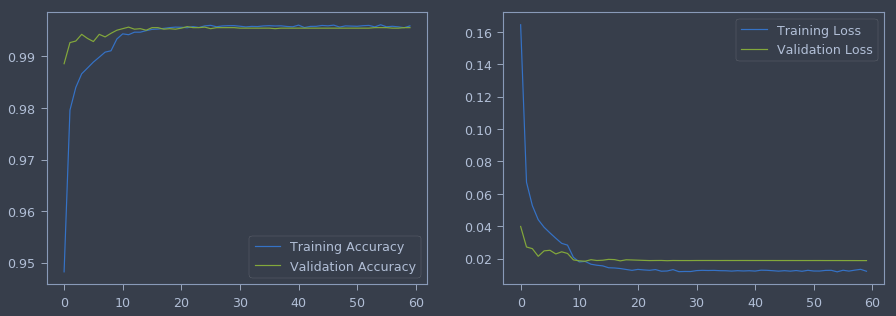

In [16]:
hist = history['Convolutional (Dropout)']

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(hist['epoch'], hist['acc'])
ax[0].plot(hist['epoch'], hist['val_acc'])
ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[1].plot(hist['epoch'], hist['loss'])
ax[1].plot(hist['epoch'], hist['val_loss'])
ax[1].legend(['Training Loss','Validation Loss'])
plt.show()

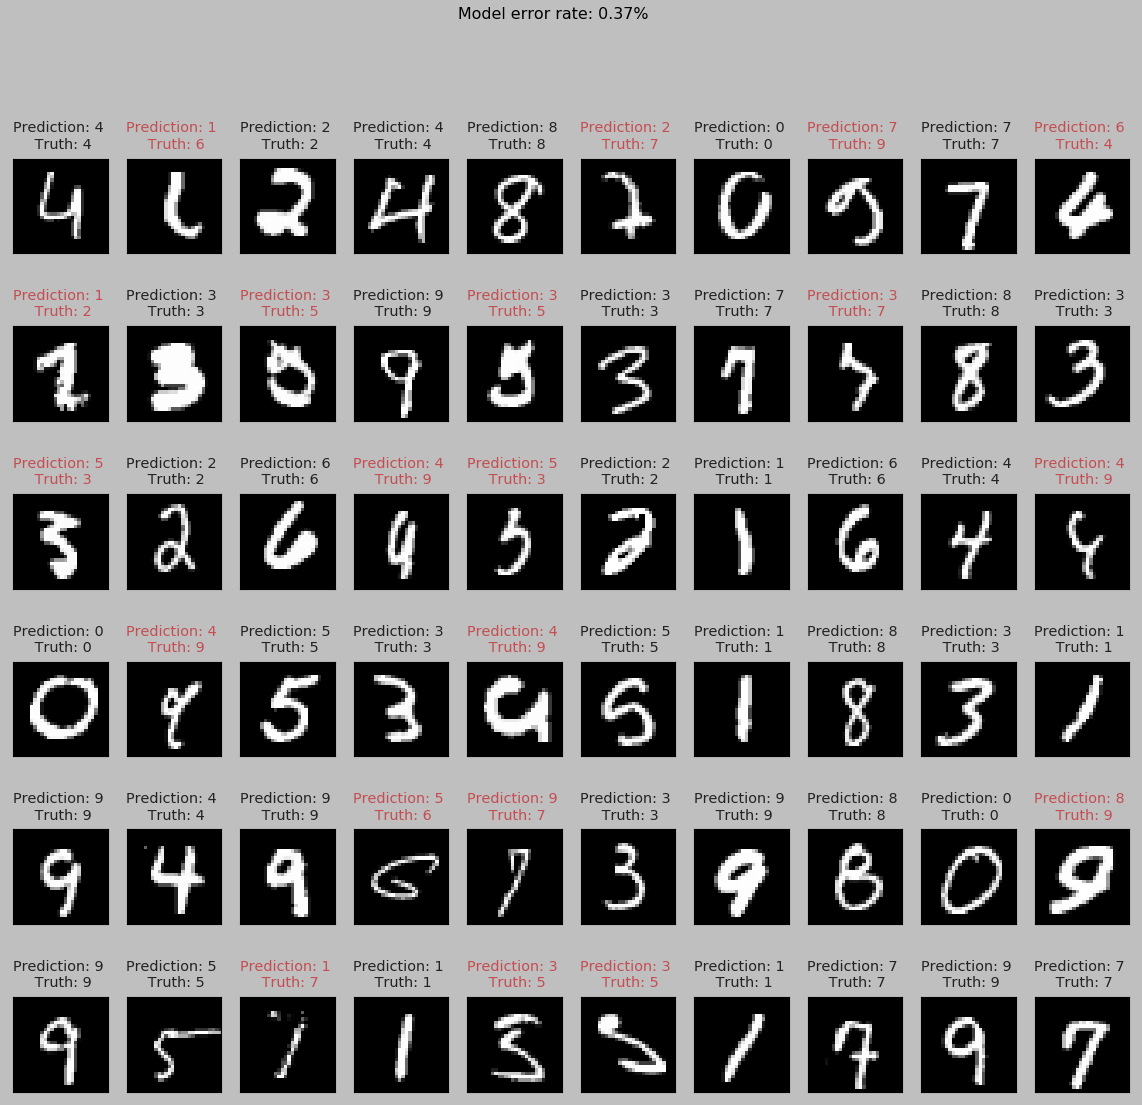

In [17]:
K.clear_session()
model = load_model(path.join('models', 'convolutional_dropout.h5'))
K.set_learning_phase(0)
show_test(model, (i_test, l_test))

Summary Plots
=============

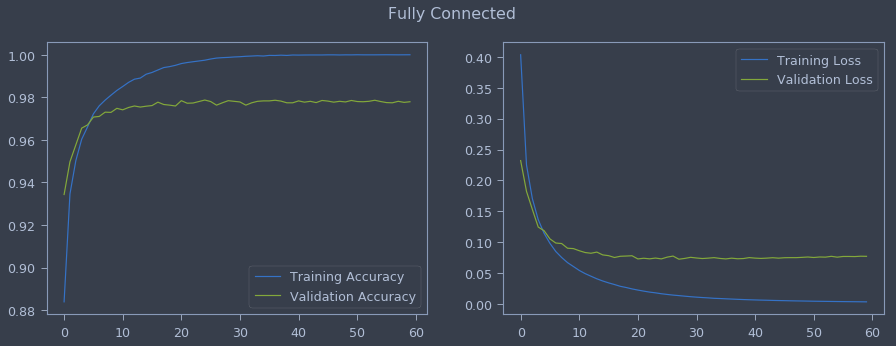

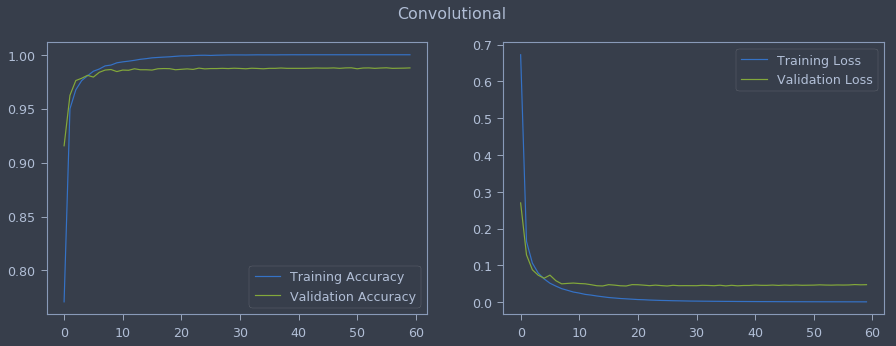

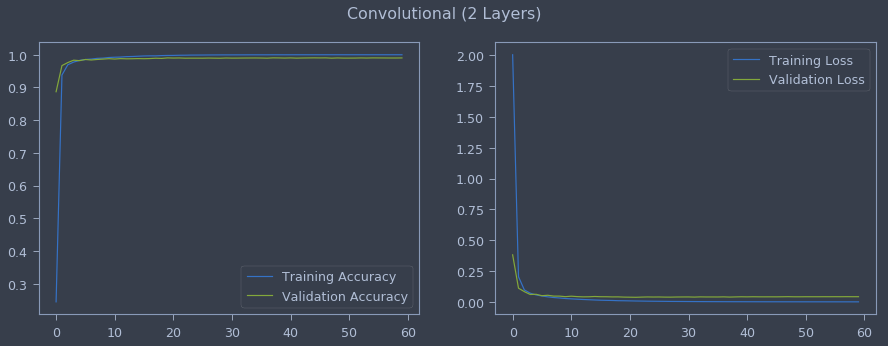

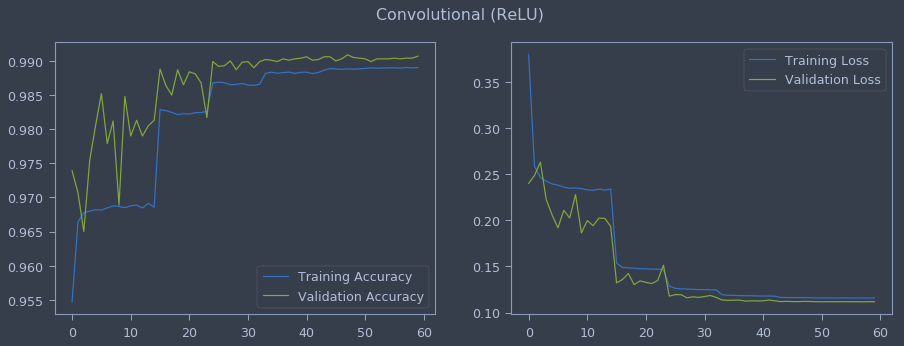

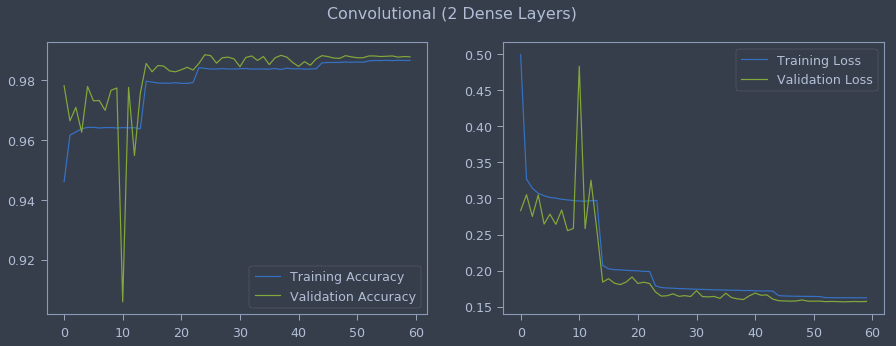

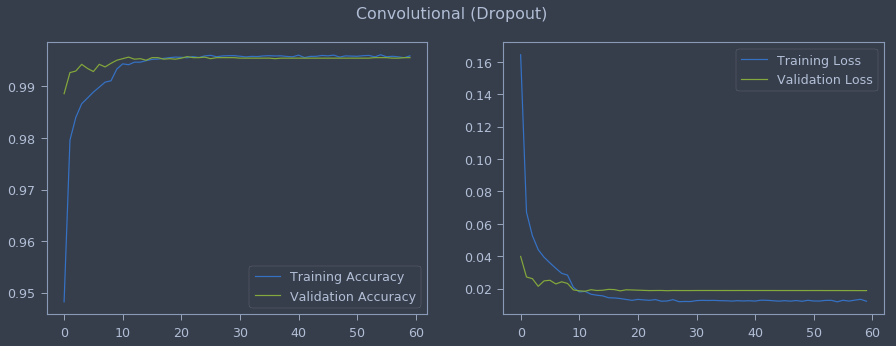

In [18]:
for name, hist in history.items():
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].plot(hist['epoch'], hist['acc'])
    ax[0].plot(hist['epoch'], hist['val_acc'])
    ax[0].legend(['Training Accuracy','Validation Accuracy'])
    ax[1].plot(hist['epoch'], hist['loss'])
    ax[1].plot(hist['epoch'], hist['val_loss'])
    ax[1].legend(['Training Loss','Validation Loss'])
    fig.suptitle(name)
plt.show()

### Possible experimentations
-----------------------------------

- What does it happen when you change the minibatch size?
- Can you find a learning rate and minibatch size that speed up learning without losing (too much) performance?
- How do you add early stopping to the equation? (Hint: there's more than a way, check Keras documentation at https://keras.io)

In [ ]:
with open(path.join('models', 'training_hist.pkl'), 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)